<a href="https://colab.research.google.com/github/dimsparagis0210/DFU-using-Deep-Learning/blob/main/YOLOv11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Πτυχιακή Εργασία

#### The goal of this BSc thesis is to develop a Deep Learning model for Object Detection. Specifically, the object of the model will be to detect ulcers in Diabetic Foots (DFU)

## Getting Dataset from Google drive

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os

# Define dataset path (adjust if needed)
dataset = 'drive/MyDrive/DFU_Data_Yolo'
trainset = dataset + '/train/images'
testset = dataset + '/test/images'
validset = dataset + '/valid/images'

# List categories (folders)
# os.listdir(original)

In [4]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import cv2

## Data Exploration

### Average Images

In [ ]:
def compute_average_image(image_dir, img_size=(224, 224)):
    all_images = []
    for file_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, file_name)
        try:
            with Image.open(img_path) as img:
                img = img.convert("RGB").resize(img_size)
                all_images.append(np.array(img, dtype=np.float32))
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

    if all_images:
        mean_image = np.mean(all_images, axis=0).astype(np.uint8)
        return mean_image
    else:
        print(f"No images found in {image_dir}.")
        return None


In [ ]:
# Compute average image for image patches
average_image = compute_average_image(trainset)

#### Visualizing Averages of the Dataset

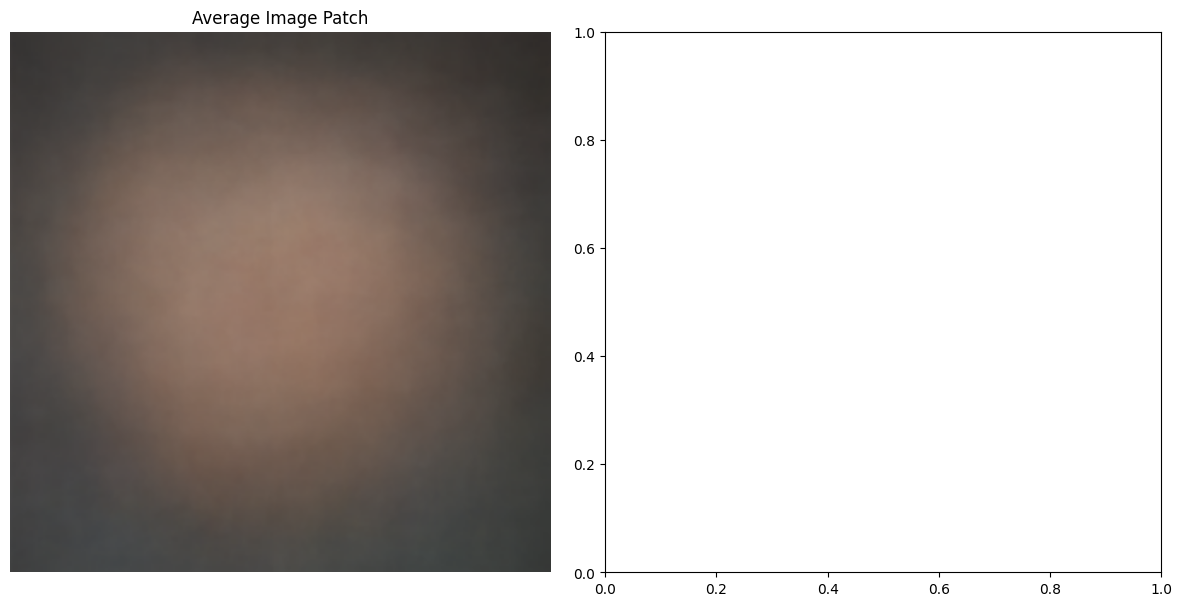

In [ ]:
# Plotting the average images
fig, axes = plt.subplots(1,2, figsize=(12, 6))

if average_image is not None:
    axes[0].imshow(average_image)
    axes[0].set_title("Average Image Patch")
    axes[0].axis("off")
else:
    axes[0].text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center')
    axes[0].set_title("Average Image Patch")
    axes[0].axis("off")

plt.tight_layout()
plt.show()



### Comparing sizes of the images in the dataset

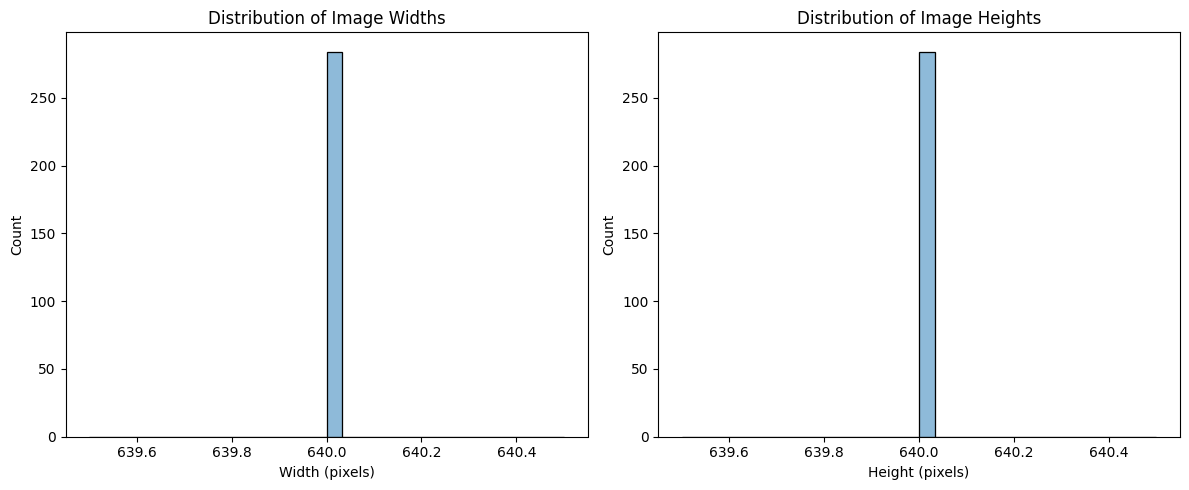

In [ ]:
widths = []
heights = []

for filename in os.listdir(trainset):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        with Image.open(os.path.join(trainset, filename)) as img:
            width, height = img.size
            widths.append(width)
            heights.append(height)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(widths, bins=30, kde=True)
plt.title('Distribution of Image Widths')
plt.xlabel('Width (pixels)')

plt.subplot(1, 2, 2)
sns.histplot(heights, bins=30, kde=True)
plt.title('Distribution of Image Heights')
plt.xlabel('Height (pixels)')

plt.tight_layout()
plt.show()


## Data Preprocessing

### Reading Dataset using Tensoflow

In [5]:
# Load dataset
batch_size = 32
img_size = (640, 640)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    'drive/MyDrive/DFU_Data_Yolo/train',
    validation_split = 0.2,
    subset = "training",
    shuffle = True,
    seed = 123,
    batch_size=batch_size,
    image_size=img_size
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    'drive/MyDrive/DFU_Data_Yolo/valid',
    validation_split = 0.2,
    subset = "validation",
    shuffle=True,
    seed = 123,
    batch_size=batch_size,
    image_size=img_size
)

# Get class names
class_names = train_dataset.class_names

Found 284 files belonging to 2 classes.
Using 228 files for training.
Found 40 files belonging to 2 classes.
Using 8 files for validation.


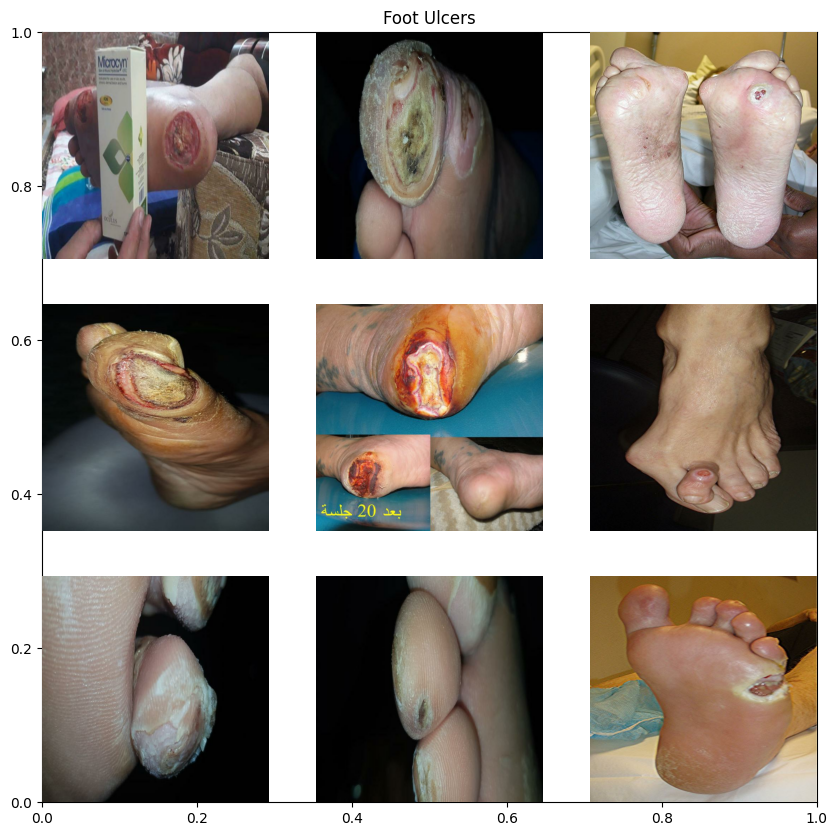

In [6]:
# Get a batch of images
plt.figure(figsize=(10, 10))
plt.title('Foot Ulcers')
for images, labels in train_dataset.take(1):  # Take one batch
    for i in range(9):  # Show 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

### Normalize Images Layer(Divide Pixel values with 255)

In [7]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

### Data Augmentation Layer

In [8]:
from keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.2),
    # Add other augmentation layers as needed
])

### Apply the preprocessing steps to the train and validation set

In [9]:
def preprocess(image, label):
    image = data_augmentation(image)
    image = normalization_layer(image)
    return image, label

train_dataset = train_dataset.map(preprocess)
validation_dataset = validation_dataset.map(preprocess)

## Model Training

### YOLOv11

In [10]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.99 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (8 CPUs, 51.0 GB RAM, 41.2/235.7 GB disk)


#### Hyperparameter Optimization

In [ ]:
from ultralytics import YOLO

search_space = {
    'lr0': (1e-4, 1e-2),       # Learning rate
    'momentum': (0.85, 0.95),  # Momentum
    'weight_decay': (1e-5, 1e-3),  # Weight decay
    'scale': (0.5, 1.5),       # Scale augmentation
    'translate': (0.0, 0.2)    # Translation augmentation
}


# Load your YOLOv8 model
model = YOLO('yolo11n.pt')

# Dataset yaml
my_yaml = '/content/drive/MyDrive/DFU_Data_Yolo/data.yaml'
os.listdir()
print(os.listdir())

# Execute hyperparameter tuning
results = model.tune(
    data=my_yaml,
    space=search_space,
    epochs=100,             # Number of epochs per trial
    optimizer='Adam',      # Optimizer choice
    plots=True             # Enable plotting of results
)


['.config', 'runs', 'yolo11n.pt', 'drive']
Tuner: Initialized Tuner instance with 'tune_dir=runs/detect/tune9'
Tuner: 💡 Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/10 with hyperparameters: {'lr0': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'scale': 0.5, 'translate': 0.1}
Saved runs/detect/tune9/tune_scatter_plots.png
Saved runs/detect/tune9/tune_fitness.png

Tuner: 1/10 iterations complete ✅ (5174.34s)
Tuner: Results saved to runs/detect/tune9
Tuner: Best fitness=0.43219 observed at iteration 1
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.86925, 'metrics/recall(B)': 0.59155, 'metrics/mAP50(B)': 0.73524, 'metrics/mAP50-95(B)': 0.39851, 'val/box_loss': 1.72394, 'val/cls_loss': 1.34102, 'val/dfl_loss': 1.6931, 'fitness': 0.43219}
Tuner: Best fitness model is runs/detect/train26
Tuner: Best fitness hyperparameters are printed below.

Printing 'runs/detect/tune9/best_hyperparameters.yaml'

lr0: 0.01
momentum

#### Model Training

In [5]:
# Train the YOLOv8 model
# lr0: 0.01
# momentum: 0.92933
# weight_decay: 0.0005
# scale: 0.5
# translate: 0.10383

from ultralytics import YOLO

# Load your YOLOv8 model
model = YOLO('yolo11n.pt')

# Dataset yaml
my_yaml = '/content/drive/MyDrive/DFU_Data_Yolo/data.yaml'

model.train(
    data=my_yaml,
    epochs=100,
    batch=16,
    imgsz=640,
    lr0=0.01,
    momentum=0.92933,
    weight_decay=0.0005,
    scale=0.5,
    translate=0.10383,
    save=True
)

# Export the model to ONNX format
model.export(format='onnx')

Ultralytics 8.3.99 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/drive/MyDrive/DFU_Data_Yolo/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_

train: Scanning /content/drive/MyDrive/DFU_Data_Yolo/train/labels.cache... 284 images, 1 backgrounds, 0 corrupt: 100%|██████████| 284/284 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/DFU_Data_Yolo/valid/labels.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.92933' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.21G       1.79      3.857      1.642         28        640: 100%|██████████| 18/18 [00:04<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.78s/it]


                   all         40         71    0.00816      0.761       0.13     0.0674

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.39G      1.828      2.833      1.505         48        640: 100%|██████████| 18/18 [00:02<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.49it/s]

                   all         40         71      0.445       0.38      0.341      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100       2.4G      1.816      2.612      1.563         21        640: 100%|██████████| 18/18 [00:03<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.06it/s]

                   all         40         71      0.607      0.141      0.295      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100       2.4G      1.874      2.499      1.591         29        640: 100%|██████████| 18/18 [00:02<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.08it/s]

                   all         40         71      0.518      0.227      0.264      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100       2.4G      1.902      2.523      1.651         30        640: 100%|██████████| 18/18 [00:02<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.29it/s]

                   all         40         71        0.4      0.423       0.33      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100       2.4G      1.906      2.392      1.699         25        640: 100%|██████████| 18/18 [00:02<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.31it/s]

                   all         40         71      0.302      0.211      0.174     0.0714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.41G      1.809      2.149      1.611         39        640: 100%|██████████| 18/18 [00:02<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.08it/s]

                   all         40         71      0.403      0.408      0.328      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.41G      1.813       2.18      1.585         27        640: 100%|██████████| 18/18 [00:02<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.34it/s]

                   all         40         71      0.469      0.493      0.462       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.43G      1.787      2.069      1.549         41        640: 100%|██████████| 18/18 [00:02<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.05it/s]

                   all         40         71      0.432      0.493      0.403      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.43G       1.84      1.978      1.599         40        640: 100%|██████████| 18/18 [00:02<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.13it/s]

                   all         40         71      0.488      0.423      0.423      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.44G       1.68       1.84      1.526         46        640: 100%|██████████| 18/18 [00:02<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.49it/s]

                   all         40         71      0.349      0.479       0.22       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.44G      1.751       1.88      1.579         22        640: 100%|██████████| 18/18 [00:02<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]

                   all         40         71      0.433      0.452      0.415      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.44G      1.708      1.792      1.502         29        640: 100%|██████████| 18/18 [00:02<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.12it/s]

                   all         40         71      0.453      0.521      0.447      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.46G      1.723       1.87       1.57         28        640: 100%|██████████| 18/18 [00:02<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.98it/s]

                   all         40         71        0.6      0.443      0.513      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.46G      1.728      1.759      1.563         38        640: 100%|██████████| 18/18 [00:02<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.99it/s]

                   all         40         71      0.439      0.507      0.464      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.46G      1.712      1.679      1.505         26        640: 100%|██████████| 18/18 [00:02<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.05it/s]

                   all         40         71      0.547      0.535      0.452      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.46G      1.683      1.598      1.484         31        640: 100%|██████████| 18/18 [00:02<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]

                   all         40         71      0.438      0.504      0.438      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.46G      1.669      1.615      1.488         28        640: 100%|██████████| 18/18 [00:02<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]

                   all         40         71      0.701      0.606      0.674      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.46G       1.68      1.609      1.505         32        640: 100%|██████████| 18/18 [00:02<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.12it/s]

                   all         40         71      0.564      0.535      0.551      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.46G        1.6      1.524      1.446         31        640: 100%|██████████| 18/18 [00:02<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.58it/s]

                   all         40         71       0.64       0.69      0.699      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.46G      1.638      1.532      1.472         33        640: 100%|██████████| 18/18 [00:02<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.62it/s]

                   all         40         71      0.766      0.647      0.687      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.46G      1.585      1.495      1.466         25        640: 100%|██████████| 18/18 [00:02<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]

                   all         40         71      0.542       0.69        0.6      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.46G      1.633      1.495      1.463         25        640: 100%|██████████| 18/18 [00:02<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.53it/s]

                   all         40         71      0.719      0.578      0.662       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.46G      1.578      1.416      1.426         20        640: 100%|██████████| 18/18 [00:02<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.44it/s]

                   all         40         71      0.553      0.662      0.579      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.46G      1.612      1.429       1.48         28        640: 100%|██████████| 18/18 [00:02<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.74it/s]

                   all         40         71      0.612        0.6      0.602      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.46G      1.626      1.435      1.488         27        640: 100%|██████████| 18/18 [00:02<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.46it/s]

                   all         40         71      0.661      0.633      0.672      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.47G      1.605      1.448      1.457         50        640: 100%|██████████| 18/18 [00:02<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.03it/s]

                   all         40         71       0.72      0.653      0.735       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.47G       1.63      1.428      1.456         40        640: 100%|██████████| 18/18 [00:02<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.58it/s]

                   all         40         71      0.716      0.563      0.683      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.47G      1.587      1.416      1.462         24        640: 100%|██████████| 18/18 [00:02<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]

                   all         40         71      0.693      0.606      0.666      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.48G      1.538      1.321      1.401         36        640: 100%|██████████| 18/18 [00:02<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.24it/s]

                   all         40         71      0.736      0.589      0.683      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.48G      1.517      1.274      1.375         37        640: 100%|██████████| 18/18 [00:02<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.44it/s]

                   all         40         71      0.628       0.69      0.686      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.48G      1.547      1.296      1.429         44        640: 100%|██████████| 18/18 [00:02<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]

                   all         40         71       0.78      0.648      0.719      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.48G      1.502      1.259      1.396         31        640: 100%|██████████| 18/18 [00:02<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.01it/s]

                   all         40         71      0.842       0.62      0.733       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.48G      1.506      1.265      1.395         28        640: 100%|██████████| 18/18 [00:02<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.13it/s]

                   all         40         71      0.716      0.639      0.686      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.48G      1.497       1.22      1.369         31        640: 100%|██████████| 18/18 [00:02<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.25it/s]

                   all         40         71      0.681      0.507      0.597      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.48G      1.513      1.271      1.403         39        640: 100%|██████████| 18/18 [00:02<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.09it/s]

                   all         40         71      0.678       0.69      0.645      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.48G       1.52      1.223      1.403         28        640: 100%|██████████| 18/18 [00:02<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.35it/s]

                   all         40         71       0.76      0.648      0.706      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.48G      1.432        1.2      1.351         28        640: 100%|██████████| 18/18 [00:02<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.27it/s]

                   all         40         71      0.773      0.634       0.72      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.48G      1.485       1.24      1.355         42        640: 100%|██████████| 18/18 [00:02<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.73it/s]

                   all         40         71      0.626      0.634      0.713      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.48G      1.493      1.229      1.367         55        640: 100%|██████████| 18/18 [00:02<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.52it/s]

                   all         40         71      0.697      0.662      0.709      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.48G      1.462      1.257      1.363         45        640: 100%|██████████| 18/18 [00:02<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]

                   all         40         71      0.645      0.704      0.741      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.48G      1.431      1.149      1.326         34        640: 100%|██████████| 18/18 [00:02<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]

                   all         40         71      0.712      0.718      0.762      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.48G      1.467      1.187      1.365         32        640: 100%|██████████| 18/18 [00:02<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]

                   all         40         71       0.78      0.634       0.69      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.48G      1.381      1.098      1.286         29        640: 100%|██████████| 18/18 [00:02<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]

                   all         40         71      0.685      0.746      0.767      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.48G        1.4      1.159      1.348         33        640: 100%|██████████| 18/18 [00:02<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.36it/s]

                   all         40         71      0.712      0.663       0.74      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.48G      1.452      1.106      1.357         34        640: 100%|██████████| 18/18 [00:02<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.30it/s]

                   all         40         71      0.802      0.571       0.72      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100       2.5G      1.512      1.124      1.371         27        640: 100%|██████████| 18/18 [00:02<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]

                   all         40         71      0.761      0.662      0.734      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100       2.5G      1.402      1.093      1.316         38        640: 100%|██████████| 18/18 [00:02<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.02it/s]

                   all         40         71      0.737      0.634      0.721      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100       2.5G      1.375      1.073      1.296         42        640: 100%|██████████| 18/18 [00:02<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.02it/s]

                   all         40         71      0.706      0.732       0.77       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100       2.5G      1.348       1.05      1.283         51        640: 100%|██████████| 18/18 [00:02<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.54it/s]

                   all         40         71      0.734       0.66      0.737      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100       2.5G      1.362      1.031      1.315         38        640: 100%|██████████| 18/18 [00:02<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.01it/s]

                   all         40         71       0.75      0.606        0.7       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100       2.5G      1.343      1.036      1.278         43        640: 100%|██████████| 18/18 [00:02<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]

                   all         40         71      0.743      0.648      0.743      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100       2.5G      1.289     0.9593      1.247         43        640: 100%|██████████| 18/18 [00:02<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.81it/s]

                   all         40         71      0.817      0.648      0.746      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100       2.5G      1.378      1.052      1.306         34        640: 100%|██████████| 18/18 [00:02<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.49it/s]

                   all         40         71      0.791      0.634      0.726      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100       2.5G      1.349      1.021       1.28         39        640: 100%|██████████| 18/18 [00:02<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.68it/s]

                   all         40         71      0.757      0.615      0.712      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100       2.5G      1.278      1.014      1.252         37        640: 100%|██████████| 18/18 [00:02<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.19it/s]

                   all         40         71      0.774      0.675      0.734        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100       2.5G      1.313      1.024      1.284         38        640: 100%|██████████| 18/18 [00:02<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.53it/s]

                   all         40         71      0.639        0.7      0.713      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100       2.5G      1.258     0.9582      1.231         41        640: 100%|██████████| 18/18 [00:02<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.00it/s]

                   all         40         71      0.775      0.634      0.732       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100       2.5G       1.33     0.9874      1.274         35        640: 100%|██████████| 18/18 [00:02<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.41it/s]

                   all         40         71       0.74       0.62      0.715      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100       2.5G      1.332     0.9694      1.248         38        640: 100%|██████████| 18/18 [00:02<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]

                   all         40         71      0.714      0.746      0.725      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100       2.5G      1.256     0.9261      1.238         29        640: 100%|██████████| 18/18 [00:02<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.46it/s]

                   all         40         71      0.668      0.707      0.752      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100       2.5G      1.301     0.9833      1.274         21        640: 100%|██████████| 18/18 [00:02<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.76it/s]

                   all         40         71      0.647      0.676      0.701      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100       2.5G      1.252     0.9369      1.242         39        640: 100%|██████████| 18/18 [00:02<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.32it/s]

                   all         40         71      0.739      0.639      0.727       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100       2.5G      1.273     0.9351       1.25         27        640: 100%|██████████| 18/18 [00:02<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.24it/s]

                   all         40         71      0.647       0.69      0.741      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100       2.5G       1.27     0.9545      1.244         25        640: 100%|██████████| 18/18 [00:02<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.62it/s]

                   all         40         71      0.813      0.648      0.756      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100       2.5G      1.266     0.9432      1.231         30        640: 100%|██████████| 18/18 [00:02<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.30it/s]

                   all         40         71      0.763      0.662      0.743      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100       2.5G      1.253     0.9453      1.246         24        640: 100%|██████████| 18/18 [00:02<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]

                   all         40         71      0.829       0.62      0.729      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100       2.5G      1.198     0.8781      1.201         32        640: 100%|██████████| 18/18 [00:02<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]

                   all         40         71      0.707       0.69       0.73      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100       2.5G      1.165     0.8504      1.178         28        640: 100%|██████████| 18/18 [00:02<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.51it/s]

                   all         40         71        0.7      0.723       0.74       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100       2.5G      1.266     0.9053       1.25         26        640: 100%|██████████| 18/18 [00:02<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.65it/s]

                   all         40         71       0.78      0.662      0.743      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100       2.5G      1.199     0.8689      1.214         26        640: 100%|██████████| 18/18 [00:02<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]

                   all         40         71      0.862      0.577      0.742      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100       2.5G      1.151      0.868      1.183         43        640: 100%|██████████| 18/18 [00:02<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.28it/s]

                   all         40         71      0.736      0.628      0.718      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100       2.5G      1.184     0.8665      1.191         35        640: 100%|██████████| 18/18 [00:02<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.64it/s]

                   all         40         71      0.801      0.622      0.732      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100       2.5G      1.205     0.8608      1.184         45        640: 100%|██████████| 18/18 [00:02<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.39it/s]

                   all         40         71      0.859      0.606      0.742      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100       2.5G       1.19     0.8766      1.195         34        640: 100%|██████████| 18/18 [00:02<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]

                   all         40         71      0.813      0.648      0.768      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100       2.5G       1.18     0.8341      1.191         32        640: 100%|██████████| 18/18 [00:02<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.46it/s]

                   all         40         71       0.81      0.659      0.766      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100       2.5G       1.15     0.8306      1.166         36        640: 100%|██████████| 18/18 [00:02<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.54it/s]

                   all         40         71      0.771      0.665      0.768      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100       2.5G       1.15      0.835      1.182         40        640: 100%|██████████| 18/18 [00:02<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]

                   all         40         71      0.765      0.662       0.75      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100       2.5G      1.134     0.8269      1.176         32        640: 100%|██████████| 18/18 [00:02<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.98it/s]

                   all         40         71      0.764      0.648      0.755      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100       2.5G      1.105     0.8056       1.17         24        640: 100%|██████████| 18/18 [00:02<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.52it/s]

                   all         40         71      0.791      0.648       0.75       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100       2.5G      1.168     0.8096      1.195         24        640: 100%|██████████| 18/18 [00:02<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]

                   all         40         71      0.814      0.648      0.745      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100       2.5G      1.109     0.7831       1.15         22        640: 100%|██████████| 18/18 [00:02<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.75it/s]

                   all         40         71      0.738      0.704      0.756      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100       2.5G      1.112      0.784      1.179         30        640: 100%|██████████| 18/18 [00:02<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]

                   all         40         71      0.717      0.746      0.767      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100       2.5G      1.092     0.7958      1.153         40        640: 100%|██████████| 18/18 [00:02<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.40it/s]

                   all         40         71      0.766      0.732        0.8      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100       2.5G      1.115     0.7921      1.155         28        640: 100%|██████████| 18/18 [00:02<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.54it/s]

                   all         40         71      0.828      0.732      0.801      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100       2.5G      1.061     0.7497      1.125         41        640: 100%|██████████| 18/18 [00:02<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.23it/s]

                   all         40         71      0.878       0.69        0.8      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100       2.5G      1.076     0.7838      1.146         29        640: 100%|██████████| 18/18 [00:02<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.16it/s]

                   all         40         71      0.801      0.704      0.785      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100       2.5G      1.118     0.8075      1.151         37        640: 100%|██████████| 18/18 [00:02<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.17it/s]

                   all         40         71      0.809      0.718      0.798      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100       2.5G      1.087     0.7917      1.156         25        640: 100%|██████████| 18/18 [00:02<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.66it/s]

                   all         40         71      0.753      0.771      0.788      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100       2.5G      1.043     0.7539      1.105         23        640: 100%|██████████| 18/18 [00:02<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.06it/s]

                   all         40         71      0.729      0.746      0.769      0.402


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100       2.5G      1.032     0.7631      1.116         27        640: 100%|██████████| 18/18 [00:03<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.27it/s]

                   all         40         71      0.724      0.777      0.791      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100       2.5G     0.9787     0.7547      1.073         34        640: 100%|██████████| 18/18 [00:02<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.51it/s]

                   all         40         71      0.743      0.775      0.786      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100       2.5G     0.9951       0.68      1.097         23        640: 100%|██████████| 18/18 [00:02<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.62it/s]

                   all         40         71      0.695      0.775      0.789      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100       2.5G       0.99     0.6811      1.103         20        640: 100%|██████████| 18/18 [00:02<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.75it/s]

                   all         40         71      0.784       0.69      0.787      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100       2.5G      1.017     0.7279      1.128         20        640: 100%|██████████| 18/18 [00:02<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.32it/s]

                   all         40         71      0.776      0.718      0.791      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100       2.5G     0.9877     0.6848      1.101         18        640: 100%|██████████| 18/18 [00:02<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.32it/s]

                   all         40         71      0.806      0.732      0.792      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100       2.5G     0.9888     0.6628      1.096         25        640: 100%|██████████| 18/18 [00:02<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.54it/s]

                   all         40         71      0.738      0.746       0.77      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100       2.5G     0.9463     0.6605      1.067         21        640: 100%|██████████| 18/18 [00:02<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]

                   all         40         71      0.738      0.732      0.773      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100       2.5G     0.9652     0.6385      1.086         25        640: 100%|██████████| 18/18 [00:02<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.09it/s]

                   all         40         71      0.732      0.718      0.772      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100       2.5G      0.947     0.6581      1.068         28        640: 100%|██████████| 18/18 [00:02<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.09it/s]

                   all         40         71      0.755      0.718      0.786      0.418



100 epochs completed in 0.103 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.99 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.38it/s]


                   all         40         71      0.828      0.732      0.801      0.455
               objects         40         71      0.828      0.732      0.801      0.455
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/train
Ultralytics 8.3.99 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 6, 8400) (5.2 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.1/144.1 kB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.8/280.8 MB 224.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

'runs/detect/train/weights/best.onnx'

#### Evaluation

In [7]:
from ultralytics import YOLO

model = YOLO('/content/runs/detect/train/weights/best.onnx')
my_yaml = '/content/drive/MyDrive/DFU_Data_Yolo/data.yaml'

# Run inference on the test set
results = model.val(data=my_yaml, split='test')

# Access and print the test set metrics
precision = results.box.map50  # Precision at IoU=0.50
recall = results.box.map  # Recall
f1_score = 2 * (precision * recall) / (precision + recall)
map50 = results.box.map50  # mAP at IoU=0.50
map50_95 = results.box.map  # mAP at IoU=0.50:0.95

print(f'Test Precision: {precision:.4f}')
print(f'Test Recall: {recall:.4f}')
print(f'Test F1 Score: {f1_score:.4f}')
print(f'Test mAP@0.50: {map50:.4f}')
print(f'Test mAP@0.50:0.95: {map50_95:.4f}')

Ultralytics 8.3.99 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Loading /content/runs/detect/train/weights/best.onnx for ONNX Runtime inference...
Using ONNX Runtime CUDAExecutionProvider
Setting batch=1 input of shape (1, 3, 640, 640)


val: Scanning /content/drive/MyDrive/DFU_Data_Yolo/test/labels.cache... 78 images, 0 backgrounds, 0 corrupt: 100%|██████████| 78/78 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:01<00:00, 63.02it/s]


                   all         78        162      0.804      0.648      0.754      0.388
               objects         78        162      0.804      0.648      0.754      0.388
Speed: 0.6ms preprocess, 8.7ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/val3
Test Precision: 0.7536
Test Recall: 0.3880
Test F1 Score: 0.5123
Test mAP@0.50: 0.7536
Test mAP@0.50:0.95: 0.3880
